In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
passengers = pd.read_csv('results/passengers.csv')
vehicles = pd.read_csv('results/vehicles.csv')

# Station coordinates
stations = {
    'A': (47.3769, 8.5417),
    'B': (47.38, 8.545),
    'C': (47.383, 8.548),
    'D': (47.386, 8.551),
    'E': (47.389, 8.554)
}

def haversine(lat1, lon1, lat2, lon2):
    """Calculate distance in km"""
    R = 6371
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# Track all passengers (minibus + bus)
print("\n=== PASSENGER TRACKING (ALL VEHICLES) ===")
print("-" * 100)

for _, p in passengers.iterrows():
    vehicle = p['assigned_vehicle'] if pd.notna(p['assigned_vehicle']) else 'Unknown Bus'
    distance = haversine(*stations[p['origin']], *stations[p['destination']])
    wait_min = p['wait_time'] / 60
    travel_min = p['travel_time'] / 60
    
    print(f"{p['passenger_id']:<5} | Vehicle: {vehicle:<15} | Route: {p['origin']} → {p['destination']:<3} | "
          f"Wait: {wait_min:>6.1f} min | Travel: {travel_min:>6.1f} min | Distance: {distance:.2f} km")

# Vehicle summary with passenger details
print("\n=== VEHICLE SUMMARY ===")
print("-" * 100)

for _, v in vehicles.iterrows():
    if v['total_passengers'] > 0:
        # Get passengers for this vehicle
        vehicle_passengers = passengers[passengers['assigned_vehicle'] == v['vehicle_id']]
        
        total_distance = sum(haversine(*stations[p['origin']], *stations[p['destination']]) 
                           for _, p in vehicle_passengers.iterrows())
        avg_wait = vehicle_passengers['wait_time'].mean() / 60
        avg_travel = vehicle_passengers['travel_time'].mean() / 60
        
        print(f"\n{v['vehicle_id']} ({v['type']})")
        print(f"  Passengers: {v['total_passengers']} | Total Distance: {total_distance:.2f} km")
        print(f"  Avg Wait Time: {avg_wait:.1f} min | Avg Travel Time: {avg_travel:.1f} min")
        print(f"  Passenger List: {', '.join(vehicle_passengers['passenger_id'].tolist())}")

# Overall statistics
print("\n=== OVERALL STATISTICS ===")
print("-" * 100)
print(f"Total Passengers: {len(passengers)}")
print(f"Active Vehicles: {len(vehicles[vehicles['total_passengers'] > 0])}")
print(f"Avg Wait Time: {passengers['wait_time'].mean() / 60:.1f} min")
print(f"Avg Travel Time: {passengers['travel_time'].mean() / 60:.1f} min")
print(f"Avg Total Time: {passengers['total_time'].mean() / 60:.1f} min")


=== PASSENGER TRACKING (ALL VEHICLES) ===
----------------------------------------------------------------------------------------------------
P1    | Vehicle: MINIBUS_2       | Route: A → C   | Wait:    5.5 min | Travel:   10.0 min | Distance: 0.83 km
P2    | Vehicle: MINIBUS_1       | Route: A → D   | Wait:    0.5 min | Travel:   15.0 min | Distance: 1.23 km
P3    | Vehicle: MINIBUS_1       | Route: B → D   | Wait:    6.0 min | Travel:    7.0 min | Distance: 0.81 km
P4    | Vehicle: MINIBUS_3       | Route: E → C   | Wait:   10.3 min | Travel:   12.0 min | Distance: 0.81 km
P5    | Vehicle: Unknown Bus     | Route: A → E   | Wait:    0.3 min | Travel:   14.0 min | Distance: 1.63 km
P6    | Vehicle: MINIBUS_2       | Route: C → E   | Wait:    5.7 min | Travel:    4.5 min | Distance: 0.81 km
P7    | Vehicle: MINIBUS_3       | Route: E → B   | Wait:   10.3 min | Travel:   18.0 min | Distance: 1.21 km

=== VEHICLE SUMMARY ===
-------------------------------------------------------------

In [51]:
data = np.load('travel_time_matrix.npy')


In [52]:
# data


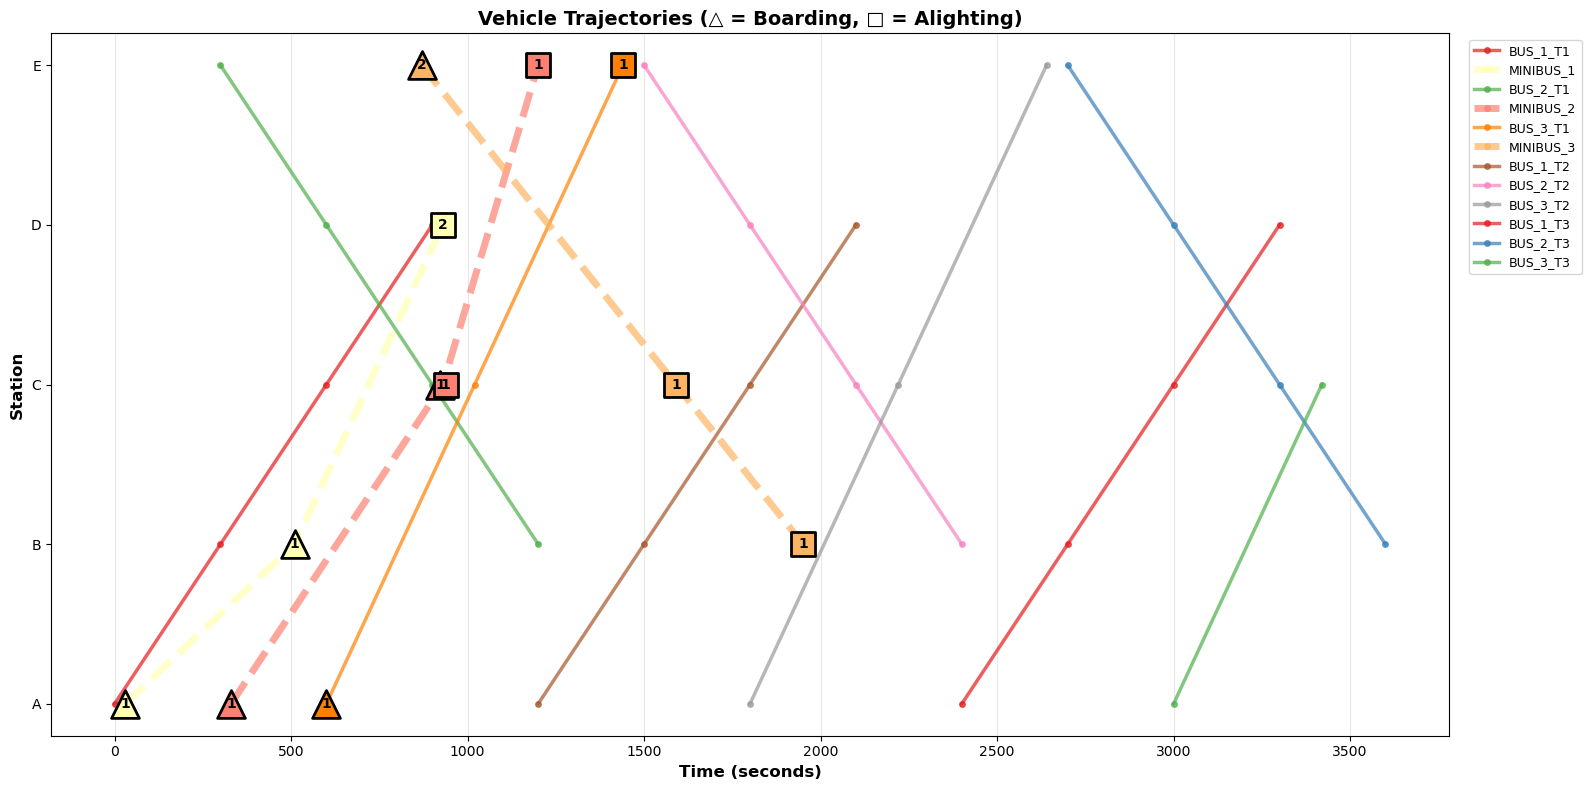

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

df = pd.read_csv('results/vehicle_states.csv')

# Define station order (y-axis)
stations = ['A', 'B', 'C', 'D', 'E']
station_to_y = {s: i for i, s in enumerate(stations)}

# Map locations to y-coordinates for all events
df['y'] = df['location'].map(station_to_y)

# Get unique vehicles
vehicles = df['vehicle_id'].unique()

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))

# Color mapping for different vehicle types
colors = {}
for vehicle in vehicles:
    if 'MINIBUS' in vehicle:
        colors[vehicle] = plt.cm.Set3(len(colors) % 12)
    else:
        colors[vehicle] = plt.cm.Set1(len(colors) % 9)

# Plot each vehicle's trajectory
for vehicle in vehicles:
    # Get arrival events for trajectory line
    arrival_data = df[(df['vehicle_id'] == vehicle) & (df['type'] == 'ARRIVAL')].sort_values('time')
    
    if len(arrival_data) > 0:
        times = arrival_data['time'].values
        y_coords = arrival_data['y'].values
        
        # Plot line
        linestyle = '--' if 'MINIBUS' in vehicle else '-'
        linewidth = 5 if 'MINIBUS' in vehicle else 2.5
        ax.plot(times, y_coords, marker='o', markersize=4, 
                label=vehicle, color=colors[vehicle], 
                linestyle=linestyle, linewidth=linewidth, alpha=0.7)

# Detect overlapping events and assign offsets
# Group events by (time, location) to detect overlaps
event_data = df[(df['type'].isin(['BOARDING', 'ALIGHTING'])) & (df['count'] > 0)].copy()
position_groups = defaultdict(list)

for idx, row in event_data.iterrows():
    key = (row['time'], row['y'])
    position_groups[key].append((idx, row))

# Assign x-offsets for overlapping events
offset_scale = 15  # Horizontal offset in time units
offsets = {}

for key, events in position_groups.items():
    if len(events) == 1:
        offsets[events[0][0]] = 0
    else:
        # Distribute events horizontally
        n = len(events)
        for i, (idx, row) in enumerate(events):
            offset = (i - (n-1)/2) * offset_scale
            offsets[idx] = offset

# Plot boarding and alighting events with offsets
for vehicle in vehicles:
    # Get boarding events (triangles)
    boarding_data = df[(df['vehicle_id'] == vehicle) & (df['type'] == 'BOARDING')]
    for idx, row in boarding_data.iterrows():
        if pd.notna(row['count']) and row['count'] > 0:
            x_offset = offsets.get(idx, 0)
            ax.scatter(row['time'] + x_offset, row['y'], marker='^', s=400, 
                      color=colors[vehicle], edgecolors='black', linewidths=2, zorder=5)
            ax.text(row['time'] + x_offset, row['y'], str(int(row['count'])), 
                   fontsize=10, fontweight='bold', ha='center', va='center',
                   color='black', zorder=6)
    
    # Get alighting events (squares)
    alighting_data = df[(df['vehicle_id'] == vehicle) & (df['type'] == 'ALIGHTING')]
    for idx, row in alighting_data.iterrows():
        if pd.notna(row['count']) and row['count'] > 0:
            x_offset = offsets.get(idx, 0)
            ax.scatter(row['time'] + x_offset, row['y'], marker='s', s=300, 
                      color=colors[vehicle], edgecolors='black', linewidths=2, zorder=5)
            ax.text(row['time'] + x_offset, row['y'], str(int(row['count'])), 
                   fontsize=10, fontweight='bold', ha='center', va='center',
                   color='black', zorder=6)

# Configure axes
ax.set_yticks(range(len(stations)))
ax.set_yticklabels(stations)
ax.set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
ax.set_ylabel('Station', fontsize=12, fontweight='bold')
ax.set_title('Vehicle Trajectories (△ = Boarding, □ = Alighting)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=9, ncol=1)

plt.tight_layout()
# plt.savefig('vehicle_trajectories.png', dpi=300, bbox_inches='tight')
plt.show()

# print("Plot saved as 'vehicle_trajectories.png'")

In [54]:
passengers 

,passenger_id,origin,destination,appear_time,board_time,arrival_time,status,wait_time,travel_time,total_time,assigned_vehicle
0,P1,A,C,0.0,330.0,930.0,ARRIVED,330.0,600.0,930.0,MINIBUS_2
1,P2,A,D,0.0,30.0,930.0,ARRIVED,30.0,900.0,930.0,MINIBUS_1
2,P3,B,D,150.0,510.0,930.0,ARRIVED,360.0,420.0,780.0,MINIBUS_1
3,P4,E,C,250.0,870.0,1590.0,ARRIVED,620.0,720.0,1340.0,MINIBUS_3
4,P5,A,E,580.0,600.0,1440.0,ARRIVED,20.0,840.0,860.0,NaN
5,P6,C,E,590.0,930.0,1200.0,ARRIVED,340.0,270.0,610.0,MINIBUS_2
6,P7,E,B,250.0,870.0,1950.0,ARRIVED,620.0,1080.0,1700.0,MINIBUS_3


In [55]:
vehicles

array(['BUS_1_T1', 'MINIBUS_1', 'BUS_2_T1', 'MINIBUS_2', 'BUS_3_T1',
       'MINIBUS_3', 'BUS_1_T2', 'BUS_2_T2', 'BUS_3_T2', 'BUS_1_T3',
       'BUS_2_T3', 'BUS_3_T3'], dtype=object)

In [56]:
with np.printoptions(threshold=np.inf, linewidth=np.inf):
    print(data)

[[[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
  [ 300.  300.  300.  300.  300.  300.  360.  360.  360.  360.  360.  360.  360.  360.  360.  360.  360.  360.  360.  360.  360.  360.  360.  360.  300.  300.  300.  300.  300.  300.  300.  300.  300.  300.  300.  300.  330.  330.  330.  330.  330.  330.  330.  330.  330.  330.  330.  330.  330.  330.  330.  330.  330.  330.  300.  300.  300.  300.  300.  300.  300.  300.  300.  300.  300.  300.  360.  360.  360.  360.  360.  360.]
  [ 600.  600.  600.  600.  600.  600.  720.  720.  720.  720.  720.  720.  720.  720.  720.  720.  720.  720.  720.  720.  720.